In [20]:
!pip install coremltools

     |████████████████████████████████| 3.4MB 6.1MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=a244d8b7ce180e2311f39e1b155221091e0fb1f08268f887c491ed19c153b3b6
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [45]:
# Initialise packages 
from u2net import U2NET
import coremltools as ct
from coremltools.proto import FeatureTypes_pb2 as ft
import torch
import os
from PIL import Image
from torchvision import transforms

In [ ]:
# Initialise our model.
net = U2NET(3,1)
device = torch.device('cpu')
net.load_state_dict(torch.load("u2net.pth", map_location=device))
net.cpu()
net.eval()

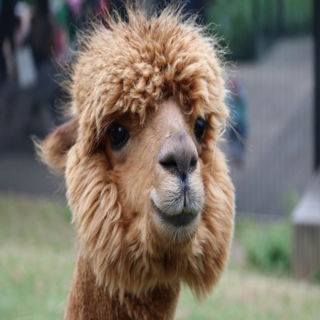

In [47]:
# Create a test input.

# Specify an image as input here
input_image = Image.open("0003.jpg").resize((320,320))
example_input = transforms.ToTensor()(input_image).unsqueeze_(0)
example_input = example_input.type(torch.FloatTensor)

display(input_image)

# or uncomment the below line to use a random Tensor instead.
# example_input = torch.rand(1,3,320,320)

In [48]:
# Trace and convert the model.
traced_model = torch.jit.trace(net, example_input)
model = ct.convert(traced_model, inputs=[ct.ImageType(name="input_1", shape=example_input.shape)])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Translating MIL ==> MLModel Ops: 100%|██████████| 1977/1977 [00:06<00:00, 299.73 ops/s]


In [49]:
# Add metadata
model.short_description = "U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
model.license = "Apache 2.0"
model.author = "Qin, Xuebin and Zhang, Zichen and Huang, Chenyang and Dehghan, Masood and Zaiane, Osmar and Jagersand, Martin"

In [50]:
# Rename inputs
spec = model.get_spec()
ct.utils.rename_feature(spec, "input_1", "in_0")
ct.utils.rename_feature(spec,"2179","out_a0")
ct.utils.rename_feature(spec,"2180","out_a1")
ct.utils.rename_feature(spec,"2181","out_a2")
ct.utils.rename_feature(spec,"2182","out_a3")
ct.utils.rename_feature(spec,"2183","out_a4")
ct.utils.rename_feature(spec,"2184","out_a5")
ct.utils.rename_feature(spec,"2185","out_a6")
model = ct.models.MLModel(spec)
model.save("u2net.mlmodel")

In [51]:
# Re-open model for modification and append new output layers.
model = ct.models.MLModel("u2net.mlmodel")
spec = model.get_spec()
spec_layers = getattr(spec, spec.WhichOneof("Type")).layers
output_layers = spec_layers[476:] # Get only the last output layers, may change with full-size U^2net
new_layers = []
layernum = 0;
for layer in output_layers:
    new_layer = spec_layers.add()
    new_layer.name = 'out_p'+str(layernum)
    new_layers.append('out_p'+str(layernum))

    new_layer.activation.linear.alpha=255
    new_layer.activation.linear.beta=0

    new_layer.input.append('out_a'+str(layernum))
    new_layer.output.append('out_p'+str(layernum))
    output_description = next(x for x in spec.description.output if x.name==output_layers[layernum].output[0])
    output_description.name = new_layer.name
    
    layernum = layernum + 1

In [52]:
# Specify the outputs as grayscale images.
for output in spec.description.output: 
    if output.name not in new_layers: 
        continue
    if output.type.WhichOneof('Type') != 'multiArrayType': 
        raise ValueError("%s is not a multiarray type" % output.name) 
    output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('GRAYSCALE')
    output.type.imageType.width = 320 
    output.type.imageType.height = 320

In [54]:
# Save our new model
updated_model = ct.models.MLModel(spec)
updated_model.save("u2net.mlmodel")

In [31]:
# Test our model.
out_dict = updated_model.predict({'in_0': input_image})
for key,value in out_dict.items():
    value.save(key+".png")

Exception: ignored